# Pobranie i analiza ofert z Allegro sprzedaży samochodów

Pytania bez odpowiedzi :
- Jak kształtują się ceny kilku samochodów z klasy średniej (mazda6, superb, avensis, passat)
- Jakie są roczne przebiegi i utraty wartości ?
- Jak na cenę wpływają dane kategoryczne (wersja wyposażenia)

Zadanie :
- Pobrać ze stron Allegro oferty sprzedaży samochodów i przeprowadzić analizy danych

### Wykorzystane :
### - Pandas  https://en.wikipedia.org/wiki/Pandas_%28software%29
### - Matplotlib https://pl.wikipedia.org/wiki/Matplotlib
### - Regresja liniowa, wielomianowa (scipy.optimize, curve_fit)
### - Wyrażenia regularne (regex) https://pl.wikipedia.org/wiki/Wyra%C5%BCenie_regularne
### - WSDL na przykładzie Allegro API https://pl.wikipedia.org/wiki/Web_Services_Description_Language


In [1]:
# Wrapper do Allegro API
# na podstawie
# https://github.com/mattrick/python-allegro-webapi/blob/master/allegro_webapi.py

import hashlib
import logging
import base64

# from suds import WebFault
# zeep nie ma tej obsługi

from zeep import Client
# zmieniony oryginalny import suds (problem z instalacją przy pythonie3) przez zeep

logger = logging.getLogger(__name__)

class AllegroWebAPI(object):
    country_code = 1  # Poland
    country_id = 1  # Poland
#   endpoint = 'https://webapi.allegro.pl.webapisandbox.pl/service.php?wsdl'
    endpoint = 'https://webapi.allegro.pl/service.php?wsdl'

    def __init__(self, api_key, login, *args, **kwargs):
        
        self.api_key = api_key
        self.login = login
        
# zmienione o możliwość podania w parametrach skrótu hasła
        self.password = kwargs.get('password', '')
        if self.password != '' :
            self.enc_passwd = base64.b64encode(hashlib.sha256(self.password.encode('utf-8')).digest()).decode()
        else :
            self.enc_passwd = kwargs.get('enc_passwd')
              
        self.client = Client(self.endpoint)
        self.service = self.client.service
        self.versions = {}

        # Retrieves component versions for each country.
        for row in self.service.doQueryAllSysStatus(countryId=self.country_id,
                                                    webapiKey=self.api_key):
            self.versions[row.countryId] = row.verKey

        self.sign_in()

    def sign_in(self):
        """Authenticates using encrypted password."""
        self.session_id = self.service.doLoginEnc(
            userLogin=self.login,
            userHashPassword=self.enc_passwd,
            countryCode=self.country_code,
            webapiKey=self.api_key,
            localVersion=self.versions[self.country_id]
        ).sessionHandlePart

    def __getattr__(self, name):
        return self._api_method(getattr(self.service, name))

    def _api_method(self, component):
        """
        A wrapper around suds components. Adds common parameters
        to each call as well as handles session expiration gracefully.
        """
        def _service(*args, **kwargs):
            # Prefill basic parameters.
            kwargs['countryCode'] = self.country_code
            kwargs['countryId'] = self.country_id
            kwargs['webapiKey'] = self.api_key
            kwargs['localVersion'] = self.versions.get(self.country_id)

            try:
                return component(*args, **kwargs)
            except :
#            except WebFault as exc:
                # Session expired - login again and retry.
#                if exc.fault.faultcode in ['ERR_NO_SESSION', 'ERR_SESSION_EXPIRED']:
                self.sign_in()
                return component(*args, **kwargs)
                raise
        return _service

In [2]:
Allegro_Credentials = {'webapiKey' : '', 'login' : '', 'enc_password' : '' } # lub otwartym tekstem 'password' : '' 

# lub z pliku
import json
with open('.Allegro_Credentials', 'r') as infile :
    Allegro_Credentials = json.load(infile)

In [3]:
def download(Allegro_filter) : 
    Allegro_chunkSize = 500
    
    x=AllegroWebAPI(api_key = Allegro_Credentials['webapiKey'], login = Allegro_Credentials['login'], 
                    enc_passwd=Allegro_Credentials['enc_password'])
    
    items_downloaded = 0
    items_to_be_downloaded = 1
    items_list = []
    
    res =[]
    
    while items_downloaded < items_to_be_downloaded :
        
        # dokumentacja do doGetItemsList
        # http://allegro.pl/webapi/documentation.php/show/id,1342
        
        res = x.service.doGetItemsList( countryId = 1, 
                                        webapiKey=Allegro_Credentials['webapiKey'], 
                                        resultSize = Allegro_chunkSize,
                                        resultOffset = items_downloaded,
                                        filterOptions= Allegro_filter)
        if res['itemsCount']==0 : 
            return []
        else :
            items_to_be_downloaded = res['itemsCount']
    
        items_list.extend(res['itemsList']['item'])
        items_downloaded += len(res['itemsList']['item'])
    
    return items_list

In [4]:
def process_records (res) :
    dset = []
    def to_dict(x) :
        res = {}
        for a in x :
            col = str(a.parameterName)
            val = a.parameterValue.item[0]
            res[col] = val
        return res

    for x in res :
        try : 
          seller = x['sellerInfo']['userLogin']
          sellertype = 'Allegro'
        except :
          try : 
            seller = x['advertInfo']['advertId']
            sellertype = x['advertInfo']['serviceId']
          except :
            seller = ''
            sellertype = 'Unknown'   
        rec ={'sellertype' : sellertype, 
              'seller' : seller, 
              'offerid' : x['itemId'],
              'title' : x['itemTitle'],
              'price' : x['priceInfo']['item'][0]['priceValue']}
        rec.update(to_dict(x['parametersInfo'].item))
        dset.append(rec)
    return dset

In [6]:
import pandas as pd

# Importowanie ofert
samochody_kategorie = '18237 - mazda 6,12678 - skoda superb,12436 - bmw3,12437 - bmw5'
samochody_kategorie = [a.split(' - ') for a in samochody_kategorie.split(',')]

counter = 0
for car in samochody_kategorie:
    counter = counter +1
    print ('Processing %s (%d of %d)' %(car[1], counter, len(samochody_kategorie))  )
    Allegro_filter = {'item' : [{'filterId':'category', 'filterValueId': car[0]} ]}
    dset = download(Allegro_filter)
    print (str(len(dset)) + ' offers downloaded.')
    df_temp = pd.DataFrame(process_records(dset))
    df_temp['car'] = car[1]
    print (str(df_temp.size) + ' dataframe created')
    if counter == 1 :
        df = df_temp
        print ('Dataframe created. Current size '+ str(df.shape))
    else :     
        df = pd.concat([df, df_temp], ignore_index=True)
        print ('Dataframes concatenated. Current size '+ str(df.shape))
    

Processing mazda 6 (1 of 4)
2256 offers downloaded.
27072 dataframe created
Dataframe created. Current size (2256, 12)
Processing skoda superb (2 of 4)
1739 offers downloaded.
20868 dataframe created
Dataframes concatenated. Current size (3995, 12)
Processing bmw3 (3 of 4)
7851 offers downloaded.
94212 dataframe created
Dataframes concatenated. Current size (11846, 12)
Processing bmw5 (4 of 4)
6027 offers downloaded.
72324 dataframe created
Dataframes concatenated. Current size (17873, 12)


In [7]:
df['car'].value_counts()

bmw3            7851
bmw5            6027
mazda 6         2256
skoda superb    1739
Name: car, dtype: int64

In [8]:
from datetime import date
df['date_imported'] = date.today()

In [9]:
# Zapisywanie ofert do lokalnego pliku
df.to_pickle('samochody_bmw.pickle')

In [16]:
# Odczytywanie pliku 
import pandas as pd
df = pd.read_pickle('samochody_bmw.pickle')

## Zaczynamy analizę danych z następującą tabelą

In [17]:
df.shape

(17873, 13)

In [18]:
df.head(5)

,Pochodzenie,Pojemność silnika (cm3),Przebieg (km),Rodzaj paliwa,Rok produkcji,Stan,offerid,price,seller,sellertype,title,car,date_imported
0,NaN,2500,143000,Benzyna,2009,Używany,7316805578,26900.0,irciak1,Allegro,MAZDA 6 SPORT 2.5 170KM SKÓRY NAVI XENON BOSE,mazda 6,2018-05-07
1,NaN,2000,2,Diesel,2008,Używany,7317341680,19900.0,dcautos,Allegro,"SUPER MAZDA 6 NAVI,ALU,SWIEZY IMPORT,GWARANC,O...",mazda 6,2018-05-07
2,NaN,2000,197000,Diesel,2007,Używany,7317363149,13900.0,dcautos,Allegro,"SUPER MAZDA 6 PO LIFCIE 2.0D SWIEZY IMPORT,OPL...",mazda 6,2018-05-07
3,NaN,1999,142640,Benzyna,2006,Używany,7317608166,18999.0,tomcio841,Allegro,MAZDA 2.0 142tys BOSE PIĘKNY KOLOR GRAFIT,mazda 6,2018-05-07
4,import,2000,129450,Benzyna,2009,Używany,7317608171,33999.0,tomcio841,Allegro,MAZDA 2.0 129oooTYS DYNAMIC G.FOTELE PIĘKNY KOLOR,mazda 6,2018-05-07


## Korygujemy przebieg ;), silnik, rocznik i opuszczamy dane, jeśli ich brakuje

In [20]:
df['Przebieg'] = pd.to_numeric(df['Przebieg (km)'], errors = 'coerce')
def korekta_przebieg(x) :
    if x> 1e7 : return x / 100
    if x> 1e6 : return x / 10
    else : return x
df['Przebieg'] = df['Przebieg'].apply(korekta_przebieg)

df['Rocznik'] = pd.to_numeric(df['Rok produkcji'], errors = 'coerce')

df['Silnik'] = pd.to_numeric(df['Pojemność silnika (cm3)'], errors = 'coerce')
def korekta_silnik(x) :
    if   x< 10   : return x * 1000
    elif x< 100  : return x * 100
    elif x< 1000 : return x * 10
    elif x> 4000 : return x / 10
    else : return x
df['Silnik'] = df['Silnik'].apply(korekta_silnik)

In [21]:
df.dropna(axis = 0, how = 'any', subset = ['Przebieg','Silnik','Rocznik'], inplace=True)
df.shape

(16987, 16)

## I zawężamy zainteresowania do konkretnego rocznika i przebiegu

In [22]:
df = df.loc[df['Rocznik']>2008,:]
df = df.loc[df['Przebieg']<300000,:]
df.shape

(7027, 16)

## Kategoryzowanie ze względu na pojemność silnika

In [23]:
df['Silnik'].value_counts().head(15)

2000.0    2110
1995.0    1629
1998.0     542
3000.0     397
1968.0     391
2993.0     283
1997.0     184
2200.0     125
2500.0     119
1800.0     114
1999.0     100
1600.0      81
1798.0      79
2191.0      78
2998.0      61
Name: Silnik, dtype: int64

In [24]:
df['Silnik'] = pd.cut(x = df['Silnik'], bins= [-1, 1405, 1605, 1905, 2005, 2205, 2505, 3000, 10000],
                                        labels = [1.4, 1.6, 1.9, 2.0, 2.2, 2.5, 3.0, 4.0])

In [25]:
df['Silnik'].value_counts()

2.0    5103
3.0     875
2.2     273
1.9     241
1.6     222
2.5     188
1.4      99
4.0      26
Name: Silnik, dtype: int64

## Mały roboczy histogram

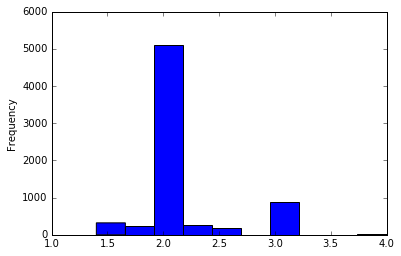

In [26]:
%matplotlib inline
#import seaborn as sns; sns.set()

df['Silnik'].astype(float).plot.hist()

## Tabela częstości silników dla wybranych marek 

In [28]:
df.pivot_table(values=['Przebieg'], aggfunc=len, index='Silnik', columns = 'car', margins=True)

Przebieg                                     
car        bmw3    bmw5 mazda 6 skoda superb     All
Silnik                                              
1.4         2.0    26.0     NaN         71.0    99.0
1.6       111.0     3.0     1.0        107.0   222.0
1.9         9.0     1.0    25.0        206.0   241.0
2.0      1739.0  1953.0   421.0        990.0  5103.0
2.2         1.0     1.0   271.0          NaN   273.0
2.5         3.0     5.0   180.0          NaN   188.0
3.0       182.0   692.0     NaN          1.0   875.0
4.0         2.0     6.0     1.0         17.0    26.0
All      2049.0  2687.0   899.0       1392.0  7027.0

## Co się kryje pod przykładową kategorią 'Octavia 1.9'

In [29]:
df.loc[((df['Silnik']==1.9) & (df['car']=='octavia')), 'Pojemność silnika (cm3)'].value_counts()

Series([], Name: Pojemność silnika (cm3), dtype: int64)

# Rocznik

In [30]:
# Ilość ogłoszeń z danego rocznika
df.pivot_table(values=['Przebieg'], aggfunc=len, index='Rocznik', columns = 'car', margins=True)

Przebieg                                     
car         bmw3    bmw5 mazda 6 skoda superb     All
Rocznik                                              
2009       321.0   135.0   159.0        103.0   718.0
2010       241.0   264.0   104.0        120.0   729.0
2011       195.0   380.0    60.0        132.0   767.0
2012       213.0   349.0    40.0        126.0   728.0
2013       297.0   312.0    95.0        160.0   864.0
2014       210.0   253.0   120.0        246.0   829.0
2015       157.0   168.0    92.0        121.0   538.0
2016        97.0   131.0   153.0         76.0   457.0
2017       239.0   610.0    75.0        123.0  1047.0
2018        79.0    85.0     1.0        185.0   350.0
All       2049.0  2687.0   899.0       1392.0  7027.0

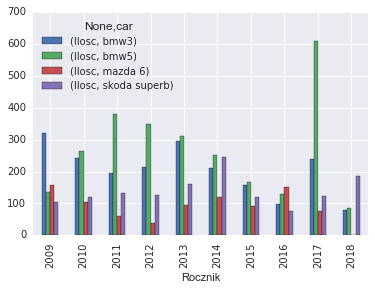

In [31]:
import seaborn as sns; sns.set()

df_temp = df.pivot_table(values=['Przebieg'], aggfunc=len, index='Rocznik', columns = 'car', margins=False)
df_temp.columns.set_levels(['Ilosc'], level=0, inplace=True)
df_temp.plot(kind='bar')

# Przebieg

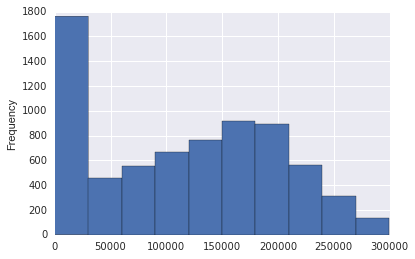

In [32]:
df['Przebieg'].astype(int).plot.hist()

In [33]:
## Zwykła regresja liniowa na przykładzie jednego samochodu

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


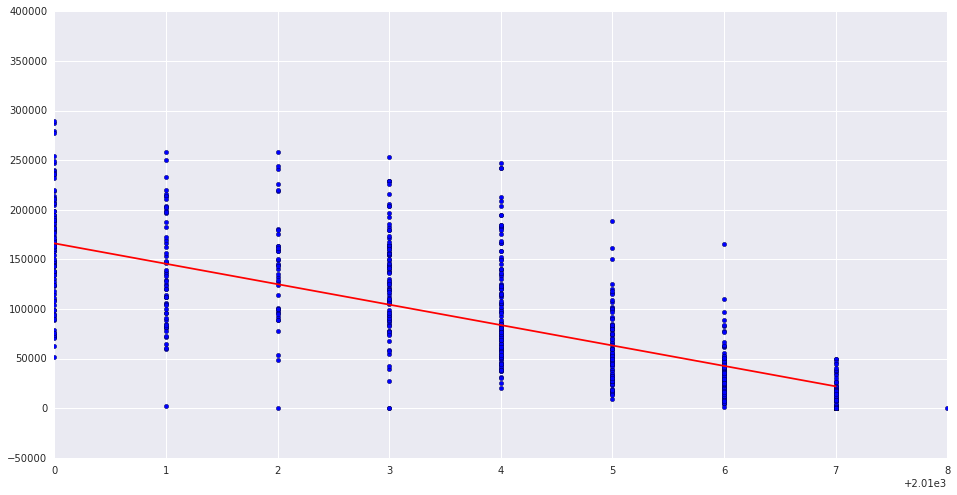

In [34]:
import matplotlib.pyplot as plt
from scipy import stats

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

df_temp = df.loc[df['car']=='mazda 6']

x = df_temp['Rocznik']
y = df_temp['Przebieg']

ax.scatter(x,y)
ax.set_xlim(2010, 2018)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

line = slope * range (2000, 2018, 1) + intercept
ax.plot(range(2000,2018), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

plt.show()

In [35]:
print ([slope, intercept, r_value, p_value, std_err])

[-20590.396064191802, 41552869.226225257, -0.77498261812402192, 5.8650566300128344e-181, 560.63680212336169]


Wyszło 20tys. km/ rok, oczywiście niedoszacowane

# Zależność cen od rocznika, regresja wielomianowa/wykładnicza

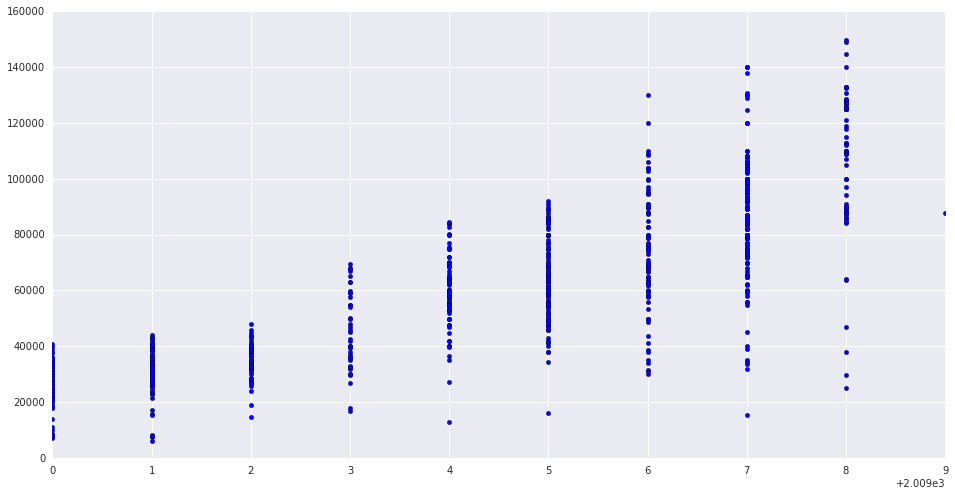

In [36]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

x = df_temp['Rocznik'].astype(float)
y = df_temp['price'].astype(float)

ax.scatter(x,y)
ax.set_xlim(2009, 2018)
ax.set_ylim(0,160000)

plt.show()

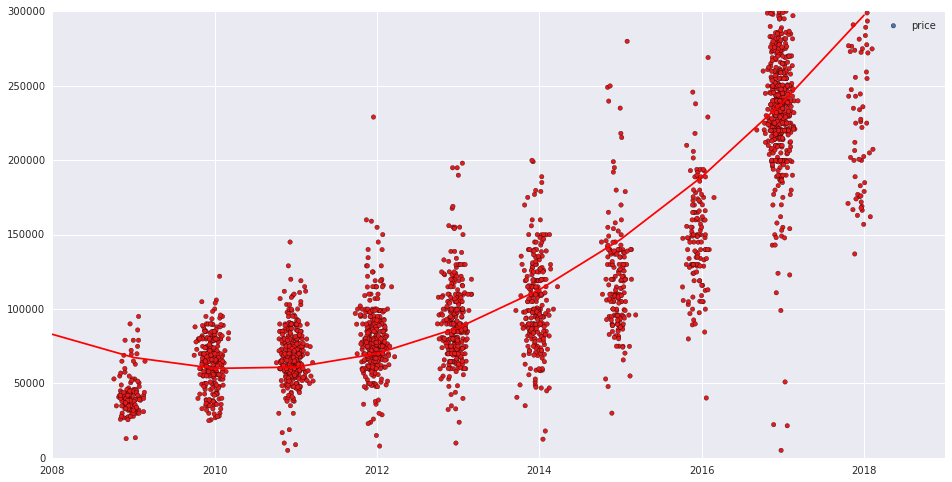

In [41]:
from scipy.optimize import curve_fit
import numpy as np

year0 = 2008

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

df_temp = df.loc[df['car']=='bmw5']

x = df_temp['Rocznik'].astype(float)
y = df_temp['price'].astype(float)
c = df_temp['car'].astype('category').cat.codes

# funkcja do regresji
def func(x, a, b, c):
    return c + a * (x -b) ** 2

popt, pcov = curve_fit(func,  x,  y,  p0=(1, year0 , 5000))

line = func (range (year0, 2019, 1), popt[0], popt[1], popt[2])
ax.plot(range(year0,2019), line, 'r')

x = x.add( pd.Series(np.random.randn(df_temp.shape[0])*0.08-0.04, index=df_temp.index))

ax.scatter(x, y, c = c, cmap='Set1', marker='o')
ax.set_xlim(year0, 2019)
ax.set_ylim(0,3e5)
ax.legend()

plt.show()

In [42]:
# Wnioski z regresji wykładniczej - utrata wartości rok do roku

In [51]:
df2 = pd.DataFrame({'price_pred':line.tolist()}, index = range (year0, 2019, 1))
df2['price loss y-y']=df2['price_pred'].diff()
df2['price loss y-y%']=df2['price loss y-y']/df2['price_pred']
df2['price loss cum']=df2['price loss y-y'].sum()-df2['price loss y-y'].cumsum()
df2['price loss cum%']=df2['price loss cum']/df2.ix[2018]['price_pred']
df2

,price_pred,price loss y-y,price loss y-y%,price loss cum,price loss cum%
2008,82974.543943,NaN,NaN,NaN,NaN
2009,67409.828525,-15564.715418,-0.230897,230081.614497,0.773406
2010,60070.980957,-7338.847568,-0.122170,237420.462065,0.798075
2011,60958.001239,887.020282,0.014551,236533.441783,0.795093
2012,70070.889372,9112.888132,0.130052,227420.553651,0.764461
2013,87409.645354,17338.755983,0.198362,210081.797668,0.706178
2014,112974.269187,25564.623833,0.226287,184517.173835,0.620244
2015,146764.760871,33790.491683,0.230236,150726.682151,0.506659
2016,188781.120404,42016.359534,0.222567,108710.322618,0.365423
2017,239023.347788,50242.227384,0.210198,58468.095234,0.196537


In [48]:
df2.ix[2018]['price_pred']

297491.44302212517

# Prezentacja wszystkich danych cenowych na jednym wykresie
## Scatterplot z hałasem (noise/jitter)

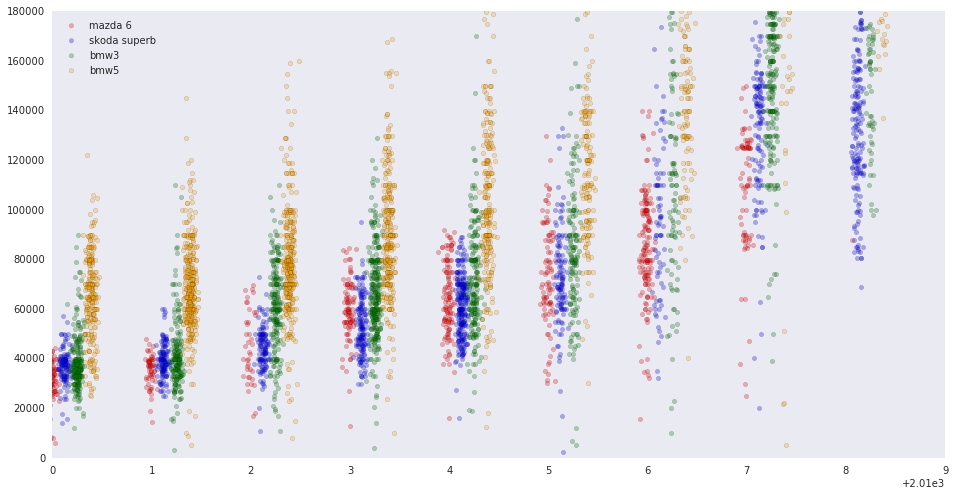

In [52]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

colors = ['red', 'blue', 'green', 'orange', 'black']

for car_ix in range(0,len(samochody_kategorie)):
    car=samochody_kategorie[car_ix][1]
    df_t = df[df['car']==car]
    x = df_t['Rocznik'].astype(float).add( pd.Series(0.8*car_ix / 6 + np.random.randn(df_t.shape[0])*0.03-0.015, index=df_t.index))
    y = df_t['price'].astype(float)
    ax.scatter(x,y,c = colors[car_ix], alpha=0.3, cmap='Set1', marker='o').set_label(car)
ax.set_xlim(2010, 2019)
#ax.set_yticks([10000,20000])
ax.grid(which='both')
ax.set_ylim(0,180000)
ax.legend(loc='upper left')

plt.show()

## Z podziałem na wersje silnikowe

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


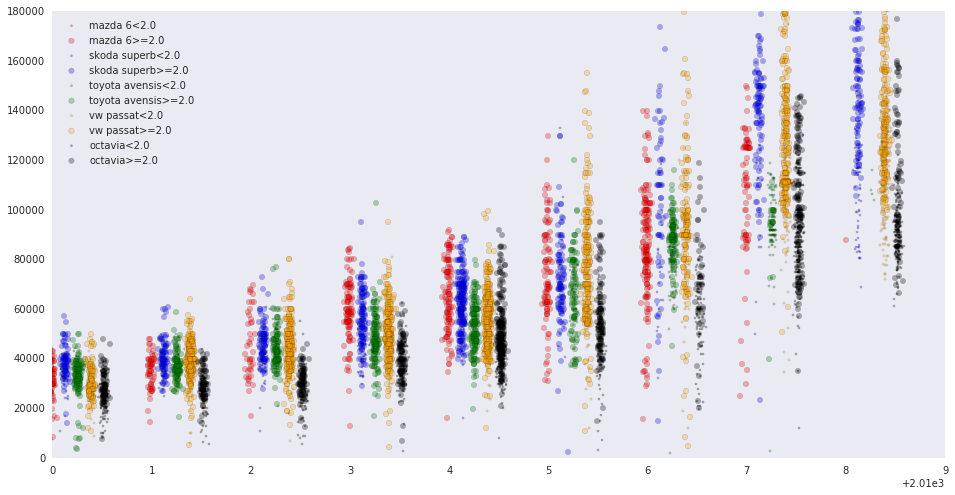

In [209]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

colors = ['red', 'blue', 'green', 'orange', 'black']

for car_ix in range(0,len(samochody_kategorie)):
    car=samochody_kategorie[car_ix][1]
    df_t = df[(df['car']==car) & (df['Silnik']<2.0)]
    x = df_t['Rocznik'].astype(float).add( pd.Series(0.8*car_ix / 6 + np.random.randn(df_t.shape[0])*0.02-0.01, index=df_t.index))
    y = df_t['price'].astype(float)
    ax.scatter(x,y,c = colors[car_ix], alpha=0.3,  cmap='Set1', marker='.').set_label(car + '<2.0')
    
    df_t = df[(df['car']==car) & (df['Silnik']>=2.0)]
    x = df_t['Rocznik'].astype(float).add( pd.Series(0.8*car_ix / 6 + np.random.randn(0.3+df_t.shape[0])*0.02-0.01, index=df_t.index))
    y = df_t['price'].astype(float)
    ax.scatter(x,y,c = colors[car_ix], alpha=0.3, s=30, cmap='Set1', marker='o').set_label(car + '>=2.0')

ax.set_xlim(2010, 2019)
#ax.set_yticks([10000,20000])
ax.grid(which='both')
ax.set_ylim(0,180000)
ax.legend(loc='upper left')

plt.show()

# Wersje wyposażenia
## Przykładowa miara odległości dla tekstu

In [210]:
df_temp = df.loc[df['car']=='mazda 6', :]
df_temp['Wersja'] = df['title'].str.lower().str.strip().str.extract('(?i)sky([a-z]+)', expand=True)
df_temp['Wersja'].value_counts()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


passion     121
activ        51
energy       39
active       25
business     16
motion        8
buisnes       3
pasion        1
actkiv        1
go            1
pssion        1
Name: Wersja, dtype: int64

In [211]:
top_labels = df_temp['Wersja'].value_counts()
words = list(top_labels.index)
words

['passion',
 'activ',
 'energy',
 'active',
 'business',
 'motion',
 'buisnes',
 'pasion',
 'actkiv',
 'go',
 'pssion']

In [212]:
good_labels = ['go', 'motion', 'energy', 'passion', 'active', 'business']

In [213]:
import difflib
for x in words :
    if x not in good_labels :
        print(x + '->' + difflib.get_close_matches(x, good_labels, n=1)[0])

activ->active
buisnes->business
pasion->passion
actkiv->active
pssion->passion


In [214]:
for x in words :
    if x not in good_labels :
        df_temp['Wersja'].replace (to_replace = x, value = difflib.get_close_matches(x, good_labels, n=1)[0], inplace = True)
df_temp['Wersja'].value_counts()

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


passion     123
active       77
energy       39
business     19
motion        8
go            1
Name: Wersja, dtype: int64

# Regresja, zmienne nominalne (kategoryczne)

In [215]:
# Najpierw przejdźmy do transformacji zmiennych na liczbowe (categorical encoding)
# zob. np. http://pbpython.com/categorical-encoding.html

In [216]:
#pd.get_dummies(obj_df, columns=["body_style", "drive_wheels"], prefix=["body", "drive"]).head()
df = pd.get_dummies(df_temp, columns = ['Rodzaj paliwa', 'Pochodzenie'])
df.head(5)

,Pojemność silnika (cm3),Przebieg (km),Rok produkcji,Stan,offerid,price,seller,sellertype,title,car,date_imported,Przebieg,Rocznik,Silnik,Wersja,Rodzaj paliwa_Benzyna,Rodzaj paliwa_Benzyna + LPG,Rodzaj paliwa_Diesel,Pochodzenie_import,Pochodzenie_krajowe
0,2200,78734,2015,Używany,7308289825,67900.0,CarsOutlet,Allegro,MAZDA 6 2.2 DIESEL 150PS FULL LED NAVI ASO AUT...,mazda 6,2018-05-03,78734.0,2015,2.2,NaN,0,0,1,1,0
1,2200,130000,2013,Używany,7308529274,60000.0,Smoczek7,Allegro,Mazda 6 III 2013 130 000 km Diesel Kombi,mazda 6,2018-05-03,130000.0,2013,2.2,NaN,0,0,1,0,0
5,2000,222975,2009,Używany,7311650392,23499.0,japancars77,Allegro,PIĘKNA MAZDA 6 2.0_DYNAMIC_FULL OPCJA_ORY.LAKIER_,mazda 6,2018-05-03,222975.0,2009,2.0,NaN,0,0,1,1,0
6,2200,201775,2009,Używany,7311971187,31900.0,pelik911,Allegro,Mazda 6 Dynamic Sport,mazda 6,2018-05-03,201775.0,2009,2.2,NaN,0,0,1,1,0
7,1998,73000,2013,Używany,7312534907,65000.0,bolekwarszawski,Allegro,Mazda 6 / 73k / Salon PL / 1 właściciel/ Prywa...,mazda 6,2018-05-03,73000.0,2013,2.0,NaN,0,0,0,0,0


In [217]:
df_temp.loc[:, 'Rok produkcji':].head(5)

,Rok produkcji,Stan,offerid,price,seller,sellertype,title,car,date_imported,Przebieg,Rocznik,Silnik,Wersja
0,2015,Używany,7308289825,67900.0,CarsOutlet,Allegro,MAZDA 6 2.2 DIESEL 150PS FULL LED NAVI ASO AUT...,mazda 6,2018-05-03,78734.0,2015,2.2,NaN
1,2013,Używany,7308529274,60000.0,Smoczek7,Allegro,Mazda 6 III 2013 130 000 km Diesel Kombi,mazda 6,2018-05-03,130000.0,2013,2.2,NaN
5,2009,Używany,7311650392,23499.0,japancars77,Allegro,PIĘKNA MAZDA 6 2.0_DYNAMIC_FULL OPCJA_ORY.LAKIER_,mazda 6,2018-05-03,222975.0,2009,2.0,NaN
6,2009,Używany,7311971187,31900.0,pelik911,Allegro,Mazda 6 Dynamic Sport,mazda 6,2018-05-03,201775.0,2009,2.2,NaN
7,2013,Używany,7312534907,65000.0,bolekwarszawski,Allegro,Mazda 6 / 73k / Salon PL / 1 właściciel/ Prywa...,mazda 6,2018-05-03,73000.0,2013,2.0,NaN
